# Traditional Feature Engineering for Text - 2018

## Resources
Split off from Sarkar's `Feature Extraction series`
 - [Understanding Feature Engineering - 3 - Unstructured text data](./NLP/pdfs/Understanding%20Feature%20Engineering%203%20-%20text%20data%20-%20Dipanjan%20Sarkar.pdf)
 - [NLP Pre Processing Workbook](./NLP_PreProcessing.ipynb) _I have copied Sarkar's workbook into myown with examples_ 

# Pre processing code

This is simply compiled from the [NLP_PreProcessing.ipynb](./NLP_PreProcessing.ipynb) which again is copied from one of Sarkar's notebooks

In [69]:
import spacy
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import contractions
import unicodedata
import matplotlib.pyplot as plt

# Download stop words if not installed already. 
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stops = stopwords.words('english')
stops_set = set(stops)
stops_set.remove('no')   # ??
stops_set.remove('not')  # ??

tokenizer = ToktokTokenizer()

# old: nlp = spacy.load('en', parse = False, tag=False, entity=False)
# Download model first using
nlp = spacy.load('en_core_web_sm')

pd.options.display.max_colwidth = 200
%matplotlib inline

%load_ext nb_js_diagrammers
import iplantuml

#--------------------------------------------
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#--------------------------------------------
def remove_accented_characters(text):
    return unicodedata.normalize(
        'NFKD', text
    ).encode(
        'ascii', 'ignore'
    ).decode('utf-8', 'ignore')

#--------------------------------------------
def expand_contractions(text, contraction_mapping = contractions.contractions_dict):
    
    # Build a complex pattern from the ORd keys of the contractions dict
    contractions_pat = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                  flags = re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]

        # Don't like this. Should simply pre-process the map to have all keys LCd
        expanded_contraction = contraction_mapping.get(match) \
            if   contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        
        return expanded_contraction

    expanded_text = contractions_pat.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#--------------------------------------------
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

#--------------------------------------------
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

#--------------------------------------------
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stops_set]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stops_set]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


#--------------------------------------------
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_characters(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

The nb_js_diagrammers extension is already loaded. To reload it, use:
  %reload_ext nb_js_diagrammers


# Loading a corpus
> Note that nltk has a ton of corpora built-in.

In [13]:
import spacy
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from contractions import contractions_dict
import unicodedata
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

import iplantuml

%load_ext nb_js_diagrammers

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)

# Pandas DF is 2D table with each column potentially being of a different data type
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


# Pre process the corpus

Calls methods defined in the `Pre processing code` section above.

In [27]:
%%mermaid_magic -h 175
flowchart TD
    txt[Text Source] --> norm[[Pre Process]]

In [7]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

['sky blue beautiful',
 'love blue beautiful sky',
 'quick brown fox jump lazy dog',
 'king breakfast sausage ham bacon egg toast bean',
 'I love green egg ham sausage bacon',
 'brown fox quick blue dog lazy',
 'sky blue sky beautiful today',
 'dog lazy brown fox quick']

# Engineering features - Bag of words

**Background**

See [Word Embeddings](./NLP%20Word%20Embeddings.ipynb) for background on `Vector Spaces`.

`Bag Of Words` _(AKA BOW)_ is one of the simplest `vector spaces` for encoding the text into numbers (_to feed a numbers based regression model_). 
 - Vocabulary built from all the words in the corpus.
 - Input vector dimensionality is the size of the vocabulary `|V|`
 - Frequency counts of words in a sentence with the count listed in the vector axis corresponding to the word in the vocabulary
 - **Ignores** Order of words and hence sequences and grammar. _Hence **bag**_

In [37]:
%%mermaid_magic
flowchart TD
    txt[Text Source] --> norm[Pre Process]
    norm --> bow[[Vectorize Space Mapping - BOW]]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# min_df and max_df ask to ignore words that have less-than or more-than
# a certain document propotion (document is sentence here).
# These in effect are document specific stop-words.
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

## Examine vocabulary, vector space

In [34]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,bacon,bean,beautiful,blue,breakfast,brown,dog,egg,fox,green,ham,jump,king,lazy,love,quick,sausage,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


# Engineering features - Bag of N-Grams

n-grams refers to a **sequence of n words** in a document (_usually a sentence_). It seeks to brinng back detection of sequences which the `BOW model` loses.
 - 1-gram would be the same as `BOW` I would think



In [50]:
%%mermaid_magic
flowchart TD
    classDef old fill:#eee,stroke:#eee

    txt[Text Source] --> norm[Pre Process]
    norm -.-> bow[Vectorize Space - BOW]:::old
    norm -->|BOW+Sequences| ngbow[[Vectorize Space - Bag of N-Grams]]

## Bag of BiGrams

In [49]:
# ngram_range refers to the range of n-grams to include.
# (2,2) only specifies bigrams. If 1-grams are also needed
# use (1,2)
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
pd.DataFrame( bv_matrix, columns=vocab)

,bacon egg,beautiful sky,beautiful today,blue beautiful,blue dog,blue sky,breakfast sausage,brown fox,dog lazy,egg ham,...,lazy dog,love blue,love green,quick blue,quick brown,sausage bacon,sausage ham,sky beautiful,sky blue,toast bean
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
7,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

**Motivation**: When you have some words (_or n-grams_) that occur across all documents/sentences, in large corpora, they can be over-emphasized. TF-IDF tries to combat this by using a normalizing/scaling factor in it's computation. This was originally developed for search engines and now is a common technique for all text processing with large corpora.

## TF
**TF** stands for Term frequency and is relative to each document/sentence in the corpus ?.

$tf(w,D)$
 - Frequency of word $w$ in document $D$.
 - Can be obtained from the _BOW Model_ as $BOW[w,D]$ 

## IDF
**IDF** Inverse document frequency for the term/word 

$IDF(w,D) = log (\dfrac{C}{df(w)})$

 - $C$ is the total number of documents/sentences in the corpus
 - $df(w)$ is the _document frequency_ of the word $w$ which is simply the number of doucments that have the word.
 - log scaling is a standard way to compress the numerical range when large variations are expected.

## TF-IDF

**TF-IDF** is a combination of both of these metrics

$TFIDF(w,D) = TF(w,D) \times IDF(D,w) = TF(w,D) \times log (\dfrac{C}{df(w)})$

👉 _Stop word removals are one way to combat this_ but then
 - You need a list
 - Needs tuning to get that list tuned to the corpus and with a rapidly changing corpus like in search can it be done ?

There are apparently variations of the above forumlas but they are roughly similar.

>👉 The encoding is floating point instead of integral frequency counts seen in earlier BOW and Bag-of-NGrams. These can be considered scaled and normalized vectors.

In [52]:
%%mermaid_magic
flowchart TD
    classDef old fill:#eee,stroke:#eee

    txt[Text Source] --> norm[Pre Process]
    norm -.-> bow[Vectorize Space - BOW]:::old
    norm -->|BOW+Sequences| ngbow[Vectorize Space - Bag of N-Grams]:::old
    norm -->|Probabilistic instead of frequency| tfidf[[TF-IDF]]

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix,2), columns=vocab)

,bacon,bean,beautiful,blue,breakfast,brown,dog,egg,fox,green,ham,jump,king,lazy,love,quick,sausage,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


# Document similarity

**Figure out how similar a document is wrt any other document**.
 - Use features extracted using models like BOW, TF-IDF etc.
 - Compute `distances` using
   - [cosine similarity/distance - Wikipedia](https://en.wikipedia.org/wiki/Cosine_similarity) $cos(\theta_{xy}) = \dfrac{X * Y}{||X|| * ||Y||}$ is the angle between two venctors in the vector space (BOW, OHE, TF-IDF etc)
   - eucledian distance - the standard RMS distance between two vectors $\sqrt{ \Sigma_i (x_i - y_i)^2}$
   - manhattan distance
   - BM25 similarity
   - Jaccard distance
  
Other resources
 - [Compare Eucledian, Cosine and Jaccard distance](https://towardsdatascience.com/3-basic-distance-measurement-in-text-mining-5852becff1d7)

Other insights
 - When using BOW for instance, longer sentences have a higher absolute frequency counts of the vocab words. The vector representation of such a long sentence has a higher magniture. The Eucledian distances and similarity in such a space will be dependent on the sentence lenght. TF-IDF encoding however normalizes things so setence length is not a large factor.
 - Cosine similarity only takes the angular distance into account, magnitude of the vector is a non-issue. This then is not skewed by longer sentences.

## Similarity using TF-IDF and Cosine similarity

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

# use the previously computed tf-idf vector encoding
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.192353,0.817246,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.225489,0.157845,0.670631,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.791821,0.000000,0.850516
3,0.000000,0.000000,0.000000,1.000000,0.506866,0.000000,0.000000,0.000000
4,0.000000,0.225489,0.000000,0.506866,1.000000,0.000000,0.000000,0.000000
5,0.192353,0.157845,0.791821,0.000000,0.000000,1.000000,0.115488,0.930989
6,0.817246,0.670631,0.000000,0.000000,0.000000,0.115488,1.000000,0.000000
7,0.000000,0.000000,0.850516,0.000000,0.000000,0.930989,0.000000,1.000000


The table above shows that documents `0, 1, 6` have high similarity scores.
  - 'sky blue beautiful'
  - 'love blue beautiful sky'
  - 'sky blue sky beautiful quick'

## Document clustering with similarity features

 Two major classes of clustering algorithms
  - **Agglomorative** which build things from the bottom up. Each document is it's own cluster and then other closters are combined as needed
    - Each document is its own cluster
    - a distance metric is used to measure distance from one cluster to another
    - a linkage merge criterion decides when to merge based on the distance
      - complete linkage
      - ward
      - average linkage
  - **Divisive** which build the entire corpus as one cluster and then starts splitting it down into clusters.

### Wards minimum variance linkage criterion

 - Each step, find the pair of clusters that leads to minimum total within-cluster variance after merging.
 - Use our existing distance metrics discussed above (tf-idf + cosine similarity distance) 

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, 
             columns=['Document\Cluster 1', 'Document\Cluster 2', 'Distance', 'Cluster size'], 
             dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster size
0,2.0,7.0,0.253098,2.0
1,0.0,6.0,0.308539,2.0
2,5.0,8.0,0.386952,3.0
3,1.0,9.0,0.489845,3.0
4,3.0,4.0,0.732945,2.0
5,11.0,12.0,2.695647,5.0
6,10.0,13.0,3.451082,8.0


The above tells us which documents (columns 2, 3 _where column 1 is the unlabeled index_) were merged in each step
 - Cluster (2,7)
 - Cluster (0,6)
 - Cluster (5,8)
 - and so on..

## Visualize clustering dendrogram

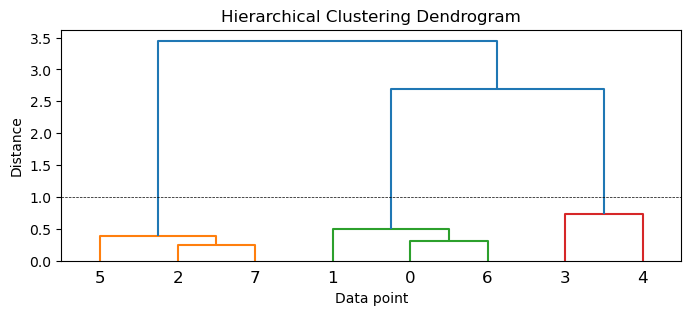

In [60]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

The above shows how each point starts as it's own cluster and then joins with other points to merge their clusters.
 - 3 major clusters if you consider a distance of 1 (dotted line) as enough to separate clusters
 - 1 cluster is you consider a distance > 3.5 as separating clusters

## Cluster based on max cluster distance

Using a `max-distance >= 1` for separating the clusters, we can get our cluster labels.

In [61]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,3
4,"I love green eggs, ham, sausages and bacon!",food,3
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1


# Topic modeling

> Note that in 2023, these pretty much use embeddings.

Topic modeling involves extracting key themes or topics from a corpus. Each topic can be represented as a bag or collection of words/terms from the corpus. Together these terms specify a topic and each topic can easily be distinguished fro mthe othres by their semantic differences.

While topic modeling is useful for summarizing documents, it is also useful in extracting features.

There are many techniques for topic modeling
 - Latent Semantic Indexing/Analysis uses matrix decomposition (SVD)
 - Latent Dirchlet Allocation uses generative probabilistic models where each document consists of multiple topics and each term or word can be assigned to a specific topic.

> Lots of details, read up more on this as needed

Frameworks like `gensim` or `scikit-learn` enable use to leverage the LDA model for generating topics.

For the purpose of feature engineering, one needs to remember that when LDA is applied on a document-term matrix _(TF-IDF or Bag or words feature matric)_, it gets decomposed into two main components
 - a `document-topic` matrix which would be the by-topic feature matric we are looking for
 - a `topic-term` matrix which helps us in loking at potential topics in the corpus.

The following code from `scikit-learn` gets us the `document-topic` matrix.

In [64]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3, max_iter=10000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features

,T1,T2,T3
0,0.832191,0.083480,0.084329
1,0.863554,0.069100,0.067346
2,0.047794,0.047776,0.904430
3,0.037243,0.925559,0.037198
4,0.049121,0.903076,0.047802
5,0.054902,0.047778,0.897321
6,0.888287,0.055697,0.056016
7,0.055704,0.055689,0.888607


The above shows which documents contribute most to the three topics (how are the topics organized?) The topics themselves and their main constituents can be discovered as follows.

In [65]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('sky', 4.3324394424701325), ('blue', 3.373774254787669), ('beautiful', 3.3323650509884386), ('today', 1.3325579855138987), ('love', 1.330415818217548)]

[('bacon', 2.33269586574902), ('egg', 2.33269586574902), ('ham', 2.33269586574902), ('sausage', 2.33269586574902), ('love', 1.3354610533796558), ('bean', 1.3327735190105536), ('breakfast', 1.3327735190105536), ('king', 1.3327735190105536), ('toast', 1.3327735190105536), ('green', 1.3325431515674175)]

[('brown', 3.3323473548404405), ('dog', 3.3323473548404405), ('fox', 3.3323473548404405), ('lazy', 3.3323473548404405), ('quick', 3.3323473548404405), ('jump', 1.3324193772908193), ('blue', 1.2919423137963386)]



 - T1 is talking about the weather (sky, blue, beautiful..)
 - T2 is talking about food
 - T3 is talking about animals..

## Document clustering with topic modeling features

Now use the document-term matrix by feeding it into k-means clustering algorithm 
 - k is the number of clusters we want (3 in this case)
 - it is a centroid based method where it trues to cluster these documents into clusters of equal variance.
 - Creates the clusters by minimizing the within-cluster sum of sqaures mean (_aka intertia_)

There are multiple ways of selecting the optimal value of `k` itself
 - sum of squared error metic
 - Silhouette Coefficients
 - Elbow method

In [68]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0, n_init='auto')
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,0
4,"I love green eggs, ham, sausages and bacon!",food,0
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beautiful today,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1
